In [1]:
!pip install scikit-learn==1.3.2 lazypredict


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [2]:
rice_df = pd.read_excel('/content/rice_w2vec_3mer_64_dataset.xlsx')


df_cold = rice_df.query('stress == "-" or stress == "cold"').replace('-', 0).replace('cold', 1)


# Define X and y (target) variables
X = df_cold.drop(['circName','stress','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)
y = df_cold['stress']



In [3]:
y.value_counts()


,count
stress,
0,50187
1,5724


In [4]:
ros = RandomUnderSampler(sampling_strategy=0.7)

X_res, y_res = ros.fit_resample(X, y)


In [5]:
y_res.value_counts()


,count
stress,
0,8177
1,5724


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=320)


In [23]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=320)
modelrf.fit(X_train, y_train)

dump(modelrf, 'rf_model_cold_3mer.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


In [11]:
from joblib import load
modelrf = load('rf_model_cold_3mer.joblib')


In [9]:
y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)


              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1646
           1       0.76      0.63      0.69      1135

    accuracy                           0.77      2781
   macro avg       0.76      0.75      0.75      2781
weighted avg       0.77      0.77      0.76      2781



In [24]:
model_lgb = lgb.LGBMClassifier(random_state=320)
model_lgb.fit(X_train, y_train)

dump(model_lgb, 'lgb_model_cold_3mer_64.joblib')
print('LGB - Cold Model created.')

[LightGBM] [Info] Number of positive: 4589, number of negative: 6531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 11120, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412680 -> initscore=-0.352898
[LightGBM] [Info] Start training from score -0.352898
LGB - Cold Model created.


In [12]:
model_lgb = load('lgb_model_cold_3mer_64.joblib')

In [13]:
y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)


              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1646
           1       0.72      0.63      0.67      1135

    accuracy                           0.75      2781
   macro avg       0.74      0.73      0.73      2781
weighted avg       0.75      0.75      0.74      2781



In [14]:
from sklearn.ensemble import ExtraTreesClassifier

modelext = ExtraTreesClassifier(random_state=320)
modelext.fit(X_train, y_train)

y_pred_ext = modelext.predict(X_test)
report = classification_report(y_test, y_pred_ext)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1646
           1       0.72      0.60      0.65      1135

    accuracy                           0.74      2781
   macro avg       0.74      0.72      0.72      2781
weighted avg       0.74      0.74      0.74      2781



In [15]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
report = classification_report(y_test, y_pred_dummy)
print(report)

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1646
           1       0.00      0.00      0.00      1135

    accuracy                           0.59      2781
   macro avg       0.30      0.50      0.37      2781
weighted avg       0.35      0.59      0.44      2781



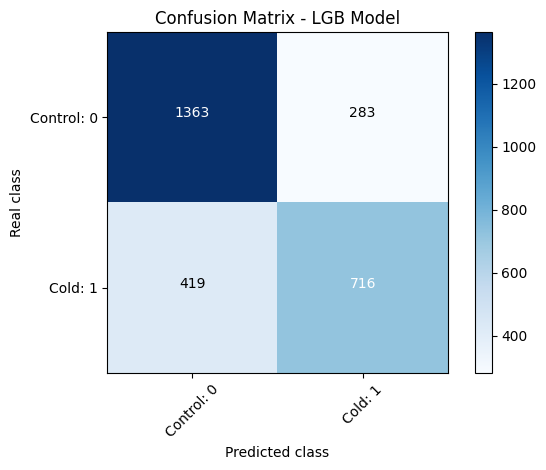

In [16]:


cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

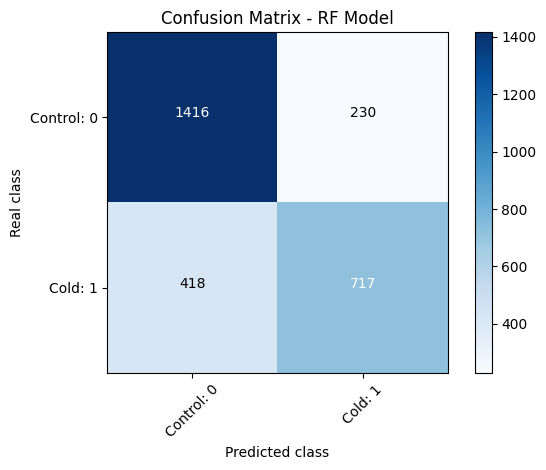

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(model_lgb, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

[LightGBM] [Info] Number of positive: 4293, number of negative: 6132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 10425, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411799 -> initscore=-0.356535
[LightGBM] [Info] Start training from score -0.356535
[LightGBM] [Info] Number of positive: 4293, number of negative: 6133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 10426, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411759 -> initscore=-0.356698
[LightGBM] [Info] Start training from score -0.356698
[LightGBM] [In

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(modelrf, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

Scores: [0.71375144 0.70935252 0.70273381 0.71856115]
Median: 0.7110997301123428


In [20]:

import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.41    1.00      0.58 0.80      0.41
1        0.10       0.44    0.98      0.61 0.80      0.48
2        0.20       0.52    0.91      0.66 0.80      0.62
3        0.30       0.59    0.83      0.69 0.80      0.69
4        0.40       0.66    0.75      0.70 0.80      0.74
5        0.50       0.72    0.63      0.67 0.80      0.75
6        0.60       0.78    0.51      0.61 0.80      0.74
7        0.70       0.81    0.36      0.50 0.80      0.71
8        0.80       0.86    0.19      0.31 0.80      0.66
9        0.90       0.90    0.02      0.05 0.80      0.60
10       1.00       0.00    0.00      0.00 0.80      0.59


In [21]:

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = modelrf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.41    1.00      0.58 0.82      0.41
1        0.10       0.44    0.99      0.61 0.82      0.49
2        0.20       0.51    0.94      0.66 0.82      0.60
3        0.30       0.58    0.85      0.69 0.82      0.69
4        0.40       0.66    0.77      0.71 0.82      0.74
5        0.50       0.74    0.64      0.69 0.82      0.76
6        0.60       0.81    0.46      0.59 0.82      0.74
7        0.70       0.83    0.28      0.42 0.82      0.68
8        0.80       0.86    0.16      0.26 0.82      0.65
9        0.90       0.84    0.03      0.06 0.82      0.60
10       1.00       0.00    0.00      0.00 0.82      0.59


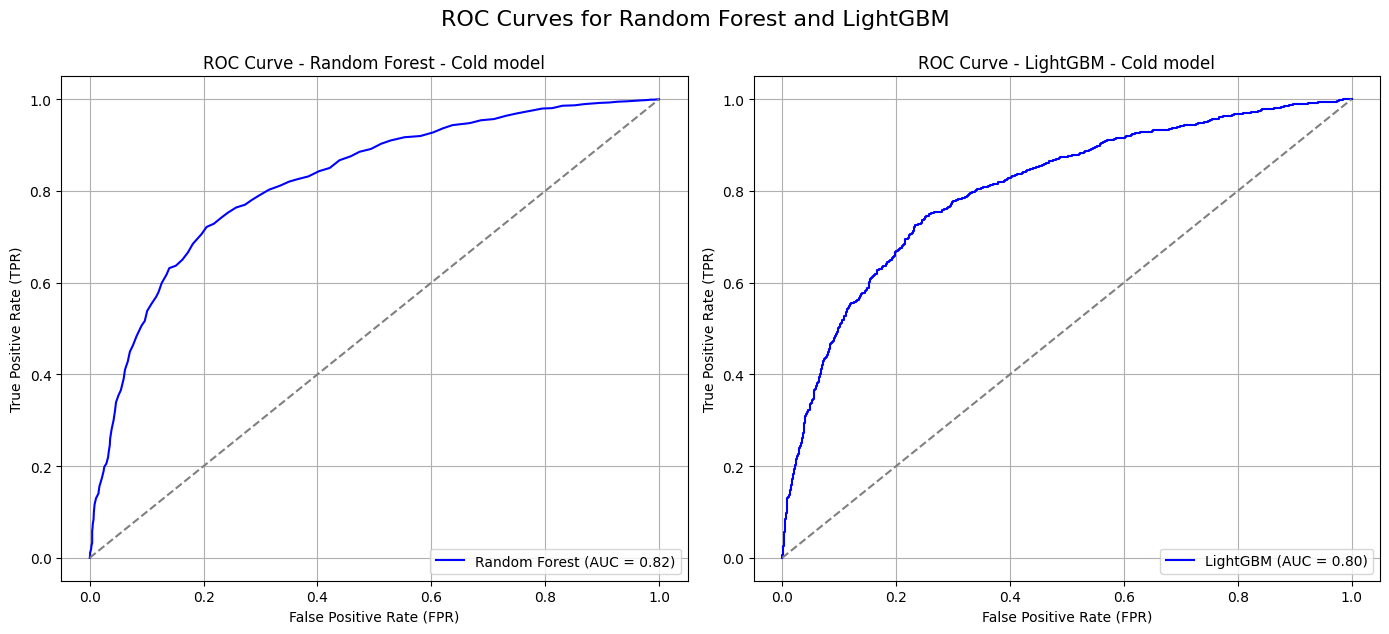

In [22]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, ax, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title(f'ROC Curve - {model_name} - Cold model')
    ax.legend(loc='lower right')
    ax.grid(True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_roc_curve(modelrf, X_test, y_test, axes[0], 'Random Forest')
plot_roc_curve(model_lgb, X_test, y_test, axes[1], 'LightGBM')

plt.tight_layout()
plt.suptitle('ROC Curves for Random Forest and LightGBM', fontsize=16, y=1.05)
plt.show()